In [80]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from model import *
from generate_data import *

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

Define the dimensions and constants of the system we're working with:

In [82]:
env = gym.make('Pendulum-v0')
env.reset()
dataGen = DataGenerator(env)
param_vec = dataGen.generate_param_vec(n_heads)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [95]:
x_dim = dataGen.sample_state().size
u_dim = dataGen.sample_action().size

n_heads = 5
layer_sizes = [32,32]

lr = 2e-4
beta1 = 0.9

batch_size = 50
N = 500

Set up the tensorflow graph

In [96]:
dyn_model = MultiHeadDynModel(x_dim, u_dim, layer_sizes, n_heads)
dyn_model.build_model()

Generate Data

In [97]:
x_data = np.zeros([N*n_heads, x_dim])
u_data = np.zeros([N*n_heads, u_dim])
xp_data = np.zeros([N*n_heads, x_dim])
ind_data = np.zeros([N*n_heads], dtype='int32')

for i, (m,p,x,u,xp) in enumerate( dataGen.do_n_steps(N, param_vec) ):
    x_data[i,:] = x
    u_data[i,:] = u
    xp_data[i,:] = xp
    ind_data[i] = m

Run and train the model on the data:

In [98]:
dyn_model.init()

In [99]:
dyn_model.train(x_data, u_data, xp_data, ind_data)
dyn_model.save()

Final Loss:  0.019451


# Old toy data:

Generate some testing data

In [43]:
x_test = np.random.randn(200).reshape([100,2])
u_test = np.zeros([100,1])
y1_test = y1(x_test)
y2_test = y2(x_test)

In [49]:
x_pred_test = dyn_model.predict(x_test, u_test)

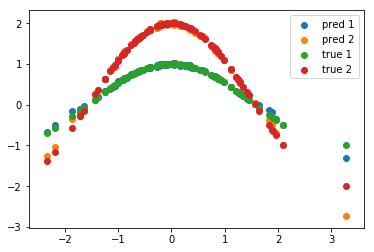

In [51]:
plt.figure()
plt.scatter(x_test[:,0], x_pred_test[0,:,0], label="pred 1")
plt.scatter(x_test[:,0], x_pred_test[1,:,0], label="pred 2")
plt.scatter(x_test[:,0], y1_test[:,0], label="true 1")
plt.scatter(x_test[:,0], y2_test[:,0], label="true 2")
plt.legend()
plt.show()

In [15]:
x_data = np.random.randn(200).reshape([100,2])
u_data = np.zeros([100,1])
y1 = lambda x_data: np.stack([np.cos(x_data[:,0]), np.sin(x_data[:,1])], axis=1)
y2 = lambda x_data: np.stack([2*np.cos(x_data[:,0]), np.sin(x_data[:,1])], axis=1)
# y1 = lambda x_data: x_data+1
# y2 = lambda x_data: 2*x_data
y1_data = y1(x_data) 
y2_data = y2(x_data)

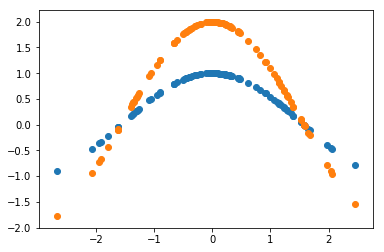

In [16]:
plt.figure()
plt.scatter(x_data[:,0], y1_data[:,0])
plt.scatter(x_data[:,0], y2_data[:,0])
plt.show()

In [31]:
x_input = np.concatenate([x_data, x_data])
u_input = np.zeros([200,1])
xp_input = np.concatenate([y1_data, y2_data])
ind_input = np.concatenate([np.zeros(100, dtype='int32'), np.ones(100,dtype='int32')]) #.reshape([200,1])
N = 200